In [1]:
from IPython.display import display, Math, Latex, HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''') 

In [15]:
#Load libraries:
from data_exploration import *
#pd.options.mode.chained_assignment = None
#for plotly distribution plots
import plotly.figure_factory as ff
#statistical libs
import scipy

In [16]:
def qq_plot(x, axes = None,device_number=1):
    if axes is None:
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 1, 1)
    else:
        ax1 = axes
    p = scipy.stats.probplot(x, plot = ax1)
    ax1.set_xlim(-3, 3)
    ax1.set_title("QQ plot for device"+str(device_number))
    return p

In [17]:
#from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
all_data=False

In [23]:
#Collect all data?
#all_data=True

#Set up test time interval:
time_interval='4w' #2w

#Set up starting point, by default if will start from current time
starting_point=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#starting_point="2019-01-24 14:00:00"  # to set upl alternative starting point

title_tail=""
query_tail=""

if not all_data:
    ##tail to all the titles
    title_tail=" over the last "+time_interval+ " back  from "+ starting_point
    ##tail for all the influxdb queries
    query_tail=" AND time >= '"+starting_point+"'-"+time_interval

In [24]:
if not all_data:#Set up test time interval:
    print("Time interval: ", time_interval)
    print("Starting point:",starting_point )
else:
    print("Selecting all data from database")

Selecting all data from database


In [25]:
#Set up influxdb connection:
client, client_df = connect_to_influxdb()

## Download speed

In [31]:
query_download = "SELECT * FROM SPEEDTEST_DOWNLOAD WHERE PROVIDER!='iperf' AND DOWNLOAD>0"+ query_tail+";"
download_df = get_dataframe_from_influxdb(client_df=client_df,query_influx=query_download,table_name='SPEEDTEST_DOWNLOAD')

In [27]:
device_numbers_d=download_df['SK_PI'].unique()
device_numbers_d=list(map(int, device_numbers_d))
device_numbers_d= sorted(device_numbers_d)

### 1.Test if data is normally distributed:

#### Visual tests

In [28]:
num_cols=4
num_rows=4
i=1
j=1
subplot_t = []
for device in device_numbers_d:
    subplot_t.append("device "+str(device))
fig = tools.make_subplots(rows=num_rows, cols=num_cols,subplot_titles=tuple(subplot_t))
for device in device_numbers_d:
    subset=download_df[download_df["SK_PI"]==device]
    trace=go.Histogram(x=subset['DOWNLOAD'],marker=dict(color=colors[device]))
    fig.append_trace(trace, i, j)
    j=j+1
    if j>num_cols:
        j=1
        i=i+1
fig['layout'].update(height=1000, width=1000, title='Download speed histogram per device')
iplot(fig)
#data = [go.Histogram(x=test_data)]
#layout = go.Layout(
#        title='Device '+str(device_number)+ ' download speed',
#        xaxis=dict(title='Download speed (Mbps)')
#    )
#
#fig = go.Figure(data=data, layout=layout)
#iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]  
[ (2,1) x5,y5 ]    [ (2,2) x6,y6 ]    [ (2,3) x7,y7 ]    [ (2,4) x8,y8 ]  
[ (3,1) x9,y9 ]    [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]



Another popular plot for checking the distribution of a data sample is the quantile-quantile plot, Q-Q plot, or QQ plot for short.

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups (e.g. 5), called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis.

A perfect match for the distribution will be shown by a line of dots on a 45-degree angle from the bottom left of the plot to the top right. Often a line is drawn on the plot to help make this expectation clear. Deviations by the dots from the line shows a deviation from the expected distribution.

We can develop a QQ plot in Python using the qqplot() statsmodels function. The function takes the data sample and by default assumes we are comparing it to a Gaussian distribution. We can draw the standardized line by setting the ‘line‘ argument to ‘s‘.

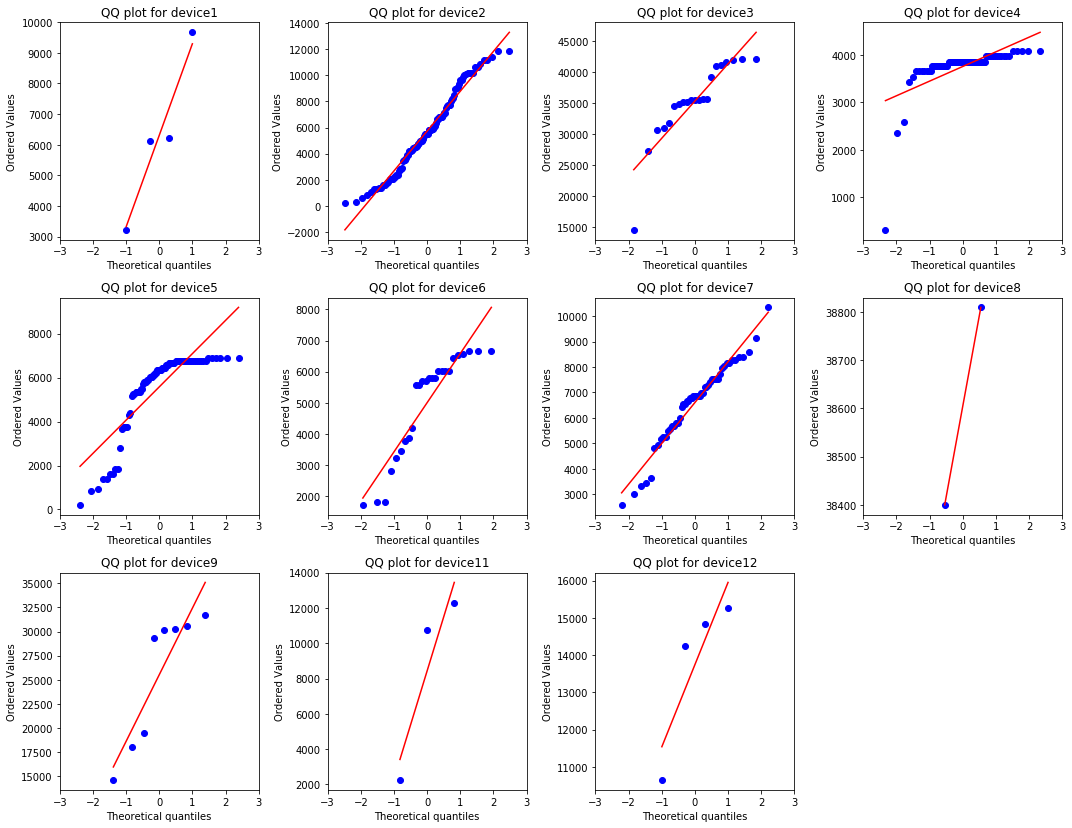

In [29]:
fig = plt.figure(figsize = (15, 15), facecolor = "white")
num_cols=4
num_rows=4
i=1
for device in device_numbers_d:
    subset=download_df[download_df["SK_PI"]==device]
    ax = fig.add_subplot(num_cols, num_rows, i)
    p = qq_plot(subset['DOWNLOAD'], ax,device_number=device)
    i=i+1

fig.tight_layout()
# q-q plot
#qqplot(test_data, line='s')
#qqplot(test_data_normalized,line='45')
#plt.show()

#### Stats tests


    H0 -  null hypothesis  - sample was drawn from a Gaussian(normal) distribution
    Ha - altenative hypothesis - smaple was not drawn from a Gaussian(normal) distribution
    alpha  - treshold (0.05)5%
    
    p <= alpha: reject H0, not normal.
    p > alpha: fail to reject H0, normal.

In [30]:
matrix_sw = []

for device in device_numbers_d:
    subset=download_df[download_df["SK_PI"]==device]
    shapiro_results =scipy.stats.shapiro(subset['DOWNLOAD'])
    ks_results = scipy.stats.kstest(subset['DOWNLOAD'], cdf='norm',args=(subset['DOWNLOAD'].mean(), subset['DOWNLOAD'].std()))
    anderson_results = scipy.stats.anderson(subset['DOWNLOAD'])
    dagostino_results = scipy.stats.normaltest(subset['DOWNLOAD'])
    #print(anderson_results)
    matrix_sw.append(
    [device, len(subset['DOWNLOAD']) - 1, shapiro_results[0], shapiro_results[1], ks_results[0], ks_results[1],
    anderson_results[0], anderson_results[1][2], dagostino_results[0], dagostino_results[1]])
#matrix_sw
df = pd.DataFrame(matrix_sw)
df.columns=['Device number', 'Degrees of freedom', 'Shapiro-Wilk Test Statistic', 'Shapiro-Wilk p-value',
     'Kolmogorov-Smirnov test Statistic','Kolmogorov-Smirnov p-value',
     'Anderson-Darling test Statistic','Anderson-Darling p-value',
     "D'Agostino's K-squared test Statistic","D'Agostino's K-squared p-value" ]
df=df.reset_index().set_index("Device number")
df.drop(['index'], axis=1, inplace=True)
df["Shapiro-Wilk p-value > 0.05"]='n'
df.loc[(df["Shapiro-Wilk p-value"]>0.05),"Shapiro-Wilk p-value > 0.05"]='y'
df["Kolmogorov-Smirnov p-value > 0.05"]='n'
df.loc[(df["Kolmogorov-Smirnov p-value"]>0.05),"Kolmogorov-Smirnov p-value > 0.05"]='y'
df["Anderson-Darling p-value > 0.05"]='n'
df.loc[(df["Anderson-Darling p-value"]>0.05),"Anderson-Darling p-value > 0.05"]='y'
df["D'Agostino's K-squared p-value > 0.05"]='n'
df.loc[(df["D'Agostino's K-squared p-value"]>0.05),"D'Agostino's K-squared p-value > 0.05"]='y'
#df[["Shapiro-Wilk p-value","Kolmogorov-Smirnov p-value","Anderson-Darling p-value","D'Agostino's K-squared p-value"]]
df[["Shapiro-Wilk p-value > 0.05","Kolmogorov-Smirnov p-value > 0.05","Anderson-Darling p-value > 0.05","D'Agostino's K-squared p-value > 0.05"]]
#stat_table =ff.create_table(matrix_sw, index=True)
#iplot(stat_table)

ValueError: skewtest is not valid with less than 8 samples; 4 samples were given.

10,11,15,7  - should be normally distributed.(We will add 3 as well as a control device)

In [14]:
normally_distributed_d=[3,11,10,15,7]

### 2.Test if normally distributed data statistically different from the threshold of 50Mbps:

For normally distributed devices  - how far are they from the treshold of 50Mbps?   
H0 - mean is = 50 (less than 50?)  
Ha - mean is greater than 50  
alpha  - treshold (0.05)5%

**1-tailed 1-sample t-test**:  
p/2 <= alpha: reject H0(mean is = 50 (less than 50?))    
t-statistics> 0 and p/2 > alpha: fail to reject H0, mean is greater than 50  

In [15]:
true_mu = 50
alpha = 0.05
for device in normally_distributed_d:
    subset=download_df[download_df["SK_PI"]==device]
    onesample_results = scipy.stats.ttest_1samp(subset["DOWNLOAD"], true_mu)
    print("Device number: ", device)
    print("Mean: ",subset["DOWNLOAD"].mean())
    print("Standart deviation: ",subset["DOWNLOAD"].std())
    print(" ",onesample_results)
    if (onesample_results[0] > 0) & (onesample_results[1]/2 < alpha):
        print("Reject the null hypothesis, mean is greater than {}".format(true_mu))
    else:
        print("Accept the null hypothesis")
    print("")


Device number:  3
Mean:  182.02640845070414
Standart deviation:  3.9015462185926504
  Ttest_1sampResult(statistic=403.24428902143853, pvalue=8.610646285314461e-218)
Reject the null hypothesis, mean is greater than 50

Device number:  11
Mean:  27.50223776223776
Standart deviation:  7.163272269364245
  Ttest_1sampResult(statistic=-37.55743141665316, pvalue=1.2404525719026046e-75)
Accept the null hypothesis

Device number:  10
Mean:  3.79844262295082
Standart deviation:  1.3575445873333305
  Ttest_1sampResult(statistic=-375.9087440274975, pvalue=1.8234120682929734e-187)
Accept the null hypothesis

Device number:  15
Mean:  17.30090909090909
Standart deviation:  3.838583202005603
  Ttest_1sampResult(statistic=-101.86681767090035, pvalue=1.2041248263393514e-134)
Accept the null hypothesis

Device number:  7
Mean:  11.358321678321676
Standart deviation:  2.531262832974317
  Ttest_1sampResult(statistic=-182.5520680437245, pvalue=2.4568874694261212e-170)
Accept the null hypothesis



In [16]:
t="Download speed by device "+title_tail
simple_boxplot(dataframe=download_df[download_df["SK_PI"].isin(normally_distributed_d)],plot_value='DOWNLOAD',sort_value='SK_PI',
               title=t, 
               ytitle="Download speed (Mbps)",
               xtitle="Device number", downloadline=True)

### 3.Test if data that is not normally distributed  statistically different from the threshold of 50Mbps

## Upload speed

In [17]:
query_upload = "SELECT * FROM SPEEDTEST_UPLOAD WHERE PROVIDER!='iperf' AND UPLOAD>0"+ query_tail+";"
upload_df = get_dataframe_from_influxdb(client_df=client_df,query_influx=query_upload,table_name='SPEEDTEST_UPLOAD')

In [18]:
device_numbers_u=upload_df['SK_PI'].unique()
device_numbers_u=list(map(int, device_numbers_u))
device_numbers_u= sorted(device_numbers_u)

### 1.Test if data is normally distributed:

#### Visual tests

In [19]:
num_cols=4
num_rows=4
i=1
j=1
subplot_t = []
for device in device_numbers_u:
    subplot_t.append("device "+str(device))
fig = tools.make_subplots(rows=num_rows, cols=num_cols,subplot_titles=tuple(subplot_t))
for device in device_numbers_u:
    subset=upload_df[upload_df["SK_PI"]==device]
    trace=go.Histogram(x=subset['UPLOAD'],marker=dict(color=colors[device]))
    fig.append_trace(trace, i, j)
    j=j+1
    if j>num_cols:
        j=1
        i=i+1
fig['layout'].update(height=1000, width=1000, title='Upload speed histogram per device')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]  
[ (2,1) x5,y5 ]    [ (2,2) x6,y6 ]    [ (2,3) x7,y7 ]    [ (2,4) x8,y8 ]  
[ (3,1) x9,y9 ]    [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]



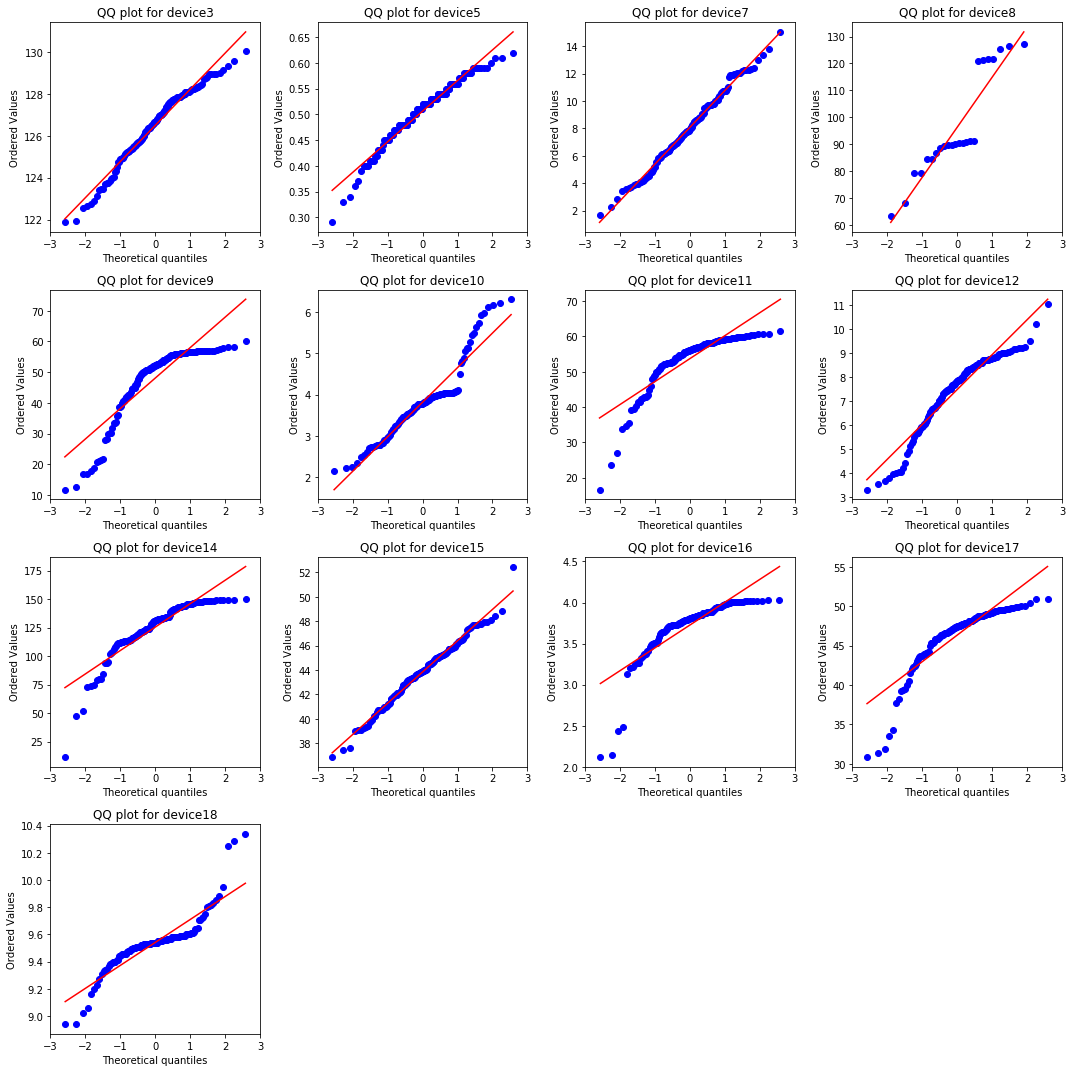

In [20]:
fig = plt.figure(figsize = (15, 15), facecolor = "white")
num_cols=4
num_rows=4
i=1
for device in device_numbers_u:
    subset=upload_df[upload_df["SK_PI"]==device]
    ax = fig.add_subplot(num_cols, num_rows, i)
    p = qq_plot(subset['UPLOAD'], ax,device_number=device)
    i=i+1

fig.tight_layout()

#### Stats tests

In [21]:
matrix_sw = []

for device in device_numbers_u:
    subset=upload_df[upload_df["SK_PI"]==device]
    shapiro_results =scipy.stats.shapiro(subset['UPLOAD'])
    ks_results = scipy.stats.kstest(subset['UPLOAD'], cdf='norm',args=(subset['UPLOAD'].mean(),subset['UPLOAD'].std()))
    anderson_results = scipy.stats.anderson(subset['UPLOAD'])
    dagostino_results = scipy.stats.normaltest(subset['UPLOAD'])
    #print(anderson_results)
    matrix_sw.append(
    [device, len(subset['UPLOAD']) - 1, shapiro_results[0], shapiro_results[1], ks_results[0], ks_results[1],
    anderson_results[0], anderson_results[1][2], dagostino_results[0], dagostino_results[1]])
#matrix_sw
df = pd.DataFrame(matrix_sw)
df.columns=['Device number', 'Degrees of freedom', 'Shapiro-Wilk Test Statistic', 'Shapiro-Wilk p-value',
     'Kolmogorov-Smirnov test Statistic','Kolmogorov-Smirnov p-value',
     'Anderson-Darling test Statistic','Anderson-Darling p-value',
     "D'Agostino's K-squared test Statistic","D'Agostino's K-squared p-value" ]
df=df.reset_index().set_index("Device number")
df.drop(['index'], axis=1, inplace=True)
df["Shapiro-Wilk p-value > 0.05"]='n'
df.loc[(df["Shapiro-Wilk p-value"]>0.05),"Shapiro-Wilk p-value > 0.05"]='y'
df["Kolmogorov-Smirnov p-value > 0.05"]='n'
df.loc[(df["Kolmogorov-Smirnov p-value"]>0.05),"Kolmogorov-Smirnov p-value > 0.05"]='y'
df["Anderson-Darling p-value > 0.05"]='n'
df.loc[(df["Anderson-Darling p-value"]>0.05),"Anderson-Darling p-value > 0.05"]='y'
df["D'Agostino's K-squared p-value > 0.05"]='n'
df.loc[(df["D'Agostino's K-squared p-value"]>0.05),"D'Agostino's K-squared p-value > 0.05"]='y'
#df[["Shapiro-Wilk p-value","Kolmogorov-Smirnov p-value","Anderson-Darling p-value","D'Agostino's K-squared p-value"]]
df[["Shapiro-Wilk p-value > 0.05","Kolmogorov-Smirnov p-value > 0.05","Anderson-Darling p-value > 0.05","D'Agostino's K-squared p-value > 0.05"]]

,Shapiro-Wilk p-value > 0.05,Kolmogorov-Smirnov p-value > 0.05,Anderson-Darling p-value > 0.05,D'Agostino's K-squared p-value > 0.05
Device number,,,,
3,n,y,y,n
5,n,y,y,n
7,y,y,y,y
8,n,n,y,y
9,n,n,y,n
10,n,n,y,n
11,n,n,y,n
12,n,n,y,n
14,n,n,y,n


Data for devices 3,5,7,15 is normally distributed.

In [22]:
normally_distributed_u=[3,5,7,15]

### 2.Test if normally distributed data statistically different from the threshold of 10Mbps:

In [23]:
true_mu = 10
alpha = 0.05
for device in normally_distributed_u:
    subset=upload_df[upload_df["SK_PI"]==device]
    onesample_results = scipy.stats.ttest_1samp(subset["UPLOAD"], true_mu)
    print("Device number: ", device)
    print("Mean: ",subset["UPLOAD"].mean())
    print("Standart deviation: ",subset["UPLOAD"].std())
    print(" ",onesample_results)
    if (onesample_results[0] > 0) & (onesample_results[1]/2 < alpha):
        print("Reject the null hypothesis, mean is greater than {}".format(true_mu))
    else:
        print("Accept the null hypothesis")
    print("")


Device number:  3
Mean:  126.49352112676057
Standart deviation:  1.7269865515388017
  Ttest_1sampResult(statistic=803.8166337244114, pvalue=5.161053460085118e-260)
Reject the null hypothesis, mean is greater than 10

Device number:  5
Mean:  0.5062937062937064
Standart deviation:  0.060043157268403216
  Ttest_1sampResult(statistic=-1890.7769085338416, pvalue=2.256141681e-314)
Accept the null hypothesis

Device number:  7
Mean:  8.080349650349651
Standart deviation:  2.660695507026129
  Ttest_1sampResult(statistic=-8.627698793824898, pvalue=1.1353621172949331e-14)
Accept the null hypothesis

Device number:  15
Mean:  43.840069930069895
Standart deviation:  2.5532320021978365
  Ttest_1sampResult(statistic=158.49260053149118, pvalue=1.15775995485922e-161)
Reject the null hypothesis, mean is greater than 10



In [24]:
t="Upload speed by device "+title_tail
simple_boxplot(dataframe=upload_df[upload_df["SK_PI"].isin(normally_distributed_u)],plot_value='UPLOAD',sort_value='SK_PI',
               title=t, 
               ytitle="Upload speed (Mbps)",
               xtitle="Device number", uploadline=True)

### 3.Test if data that is not normally distributed  statistically different from the threshold of 10Mbps

## Ping latency(speedtest)

In [25]:
query_ping1 = "SELECT * FROM SPEEDTEST_PING WHERE PROVIDER!='iperf' AND PING>0"+ query_tail+";"
ping_df1 = get_dataframe_from_influxdb(client_df=client_df,query_influx=query_ping1,table_name='SPEEDTEST_PING')

In [26]:
device_numbers_p1=ping_df1['SK_PI'].unique()
device_numbers_p1=list(map(int, device_numbers_p1))
device_numbers_p1= sorted(device_numbers_p1)

### 1.Test if data is normally distributed:

#### Visual tests

In [27]:
num_cols=4
num_rows=4
i=1
j=1
subplot_t = []
for device in device_numbers_p1:
    subplot_t.append("device "+str(device))
fig = tools.make_subplots(rows=num_rows, cols=num_cols,subplot_titles=tuple(subplot_t))
for device in device_numbers_p1:
    subset=ping_df1[ping_df1["SK_PI"]==device]
    trace=go.Histogram(x=subset['PING'],marker=dict(color=colors[device]))
    fig.append_trace(trace, i, j)
    j=j+1
    if j>num_cols:
        j=1
        i=i+1
fig['layout'].update(height=1000, width=1000, title='Ping latency histogram per device')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]  
[ (2,1) x5,y5 ]    [ (2,2) x6,y6 ]    [ (2,3) x7,y7 ]    [ (2,4) x8,y8 ]  
[ (3,1) x9,y9 ]    [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]



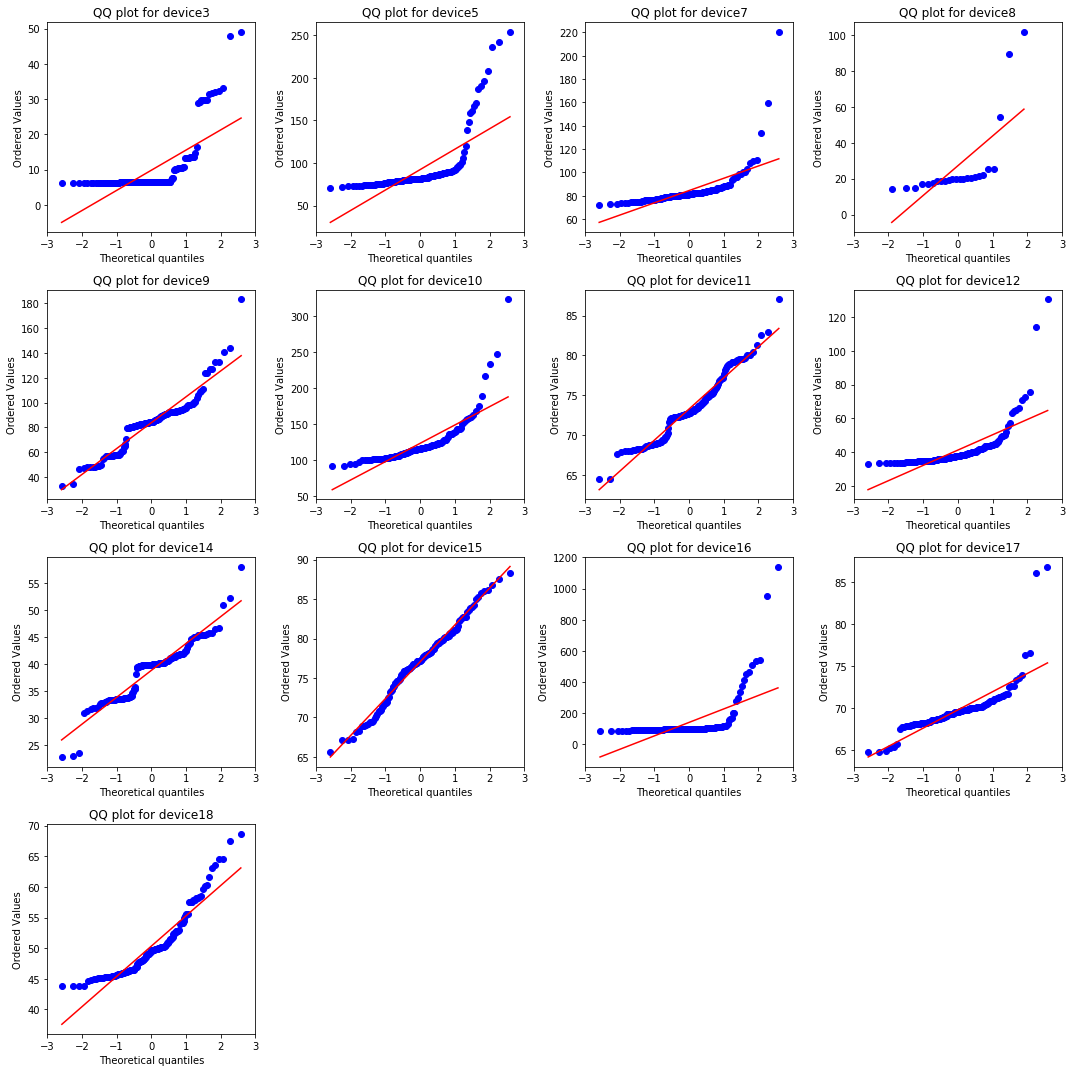

In [28]:
fig = plt.figure(figsize = (15, 15), facecolor = "white")
num_cols=4
num_rows=4
i=1
for device in device_numbers_u:
    subset=ping_df1[ping_df1["SK_PI"]==device]
    ax = fig.add_subplot(num_cols, num_rows, i)
    p = qq_plot(subset['PING'], ax,device_number=device)
    i=i+1

fig.tight_layout()

In [29]:
matrix_sw = []

for device in device_numbers_p1:
    subset=ping_df1[ping_df1["SK_PI"]==device]
    shapiro_results =scipy.stats.shapiro(subset['PING'])
    ks_results = scipy.stats.kstest(subset['PING'], cdf='norm',args=(subset['PING'].mean(),subset['PING'].std()))
    anderson_results = scipy.stats.anderson(subset['PING'])
    dagostino_results = scipy.stats.normaltest(subset['PING'])
    #print(anderson_results)
    matrix_sw.append(
    [device, len(subset['PING']) - 1, shapiro_results[0], shapiro_results[1], ks_results[0], ks_results[1],
    anderson_results[0], anderson_results[1][2], dagostino_results[0], dagostino_results[1]])
#matrix_sw
df = pd.DataFrame(matrix_sw)
df.columns=['Device number', 'Degrees of freedom', 'Shapiro-Wilk Test Statistic', 'Shapiro-Wilk p-value',
     'Kolmogorov-Smirnov test Statistic','Kolmogorov-Smirnov p-value',
     'Anderson-Darling test Statistic','Anderson-Darling p-value',
     "D'Agostino's K-squared test Statistic","D'Agostino's K-squared p-value" ]
df=df.reset_index().set_index("Device number")
df.drop(['index'], axis=1, inplace=True)
df["Shapiro-Wilk p-value > 0.05"]='n'
df.loc[(df["Shapiro-Wilk p-value"]>0.05),"Shapiro-Wilk p-value > 0.05"]='y'
df["Kolmogorov-Smirnov p-value > 0.05"]='n'
df.loc[(df["Kolmogorov-Smirnov p-value"]>0.05),"Kolmogorov-Smirnov p-value > 0.05"]='y'
df["Anderson-Darling p-value > 0.05"]='n'
df.loc[(df["Anderson-Darling p-value"]>0.05),"Anderson-Darling p-value > 0.05"]='y'
df["D'Agostino's K-squared p-value > 0.05"]='n'
df.loc[(df["D'Agostino's K-squared p-value"]>0.05),"D'Agostino's K-squared p-value > 0.05"]='y'
#df[["Shapiro-Wilk p-value","Kolmogorov-Smirnov p-value","Anderson-Darling p-value","D'Agostino's K-squared p-value"]]
df[["Shapiro-Wilk p-value > 0.05","Kolmogorov-Smirnov p-value > 0.05","Anderson-Darling p-value > 0.05","D'Agostino's K-squared p-value > 0.05"]]

,Shapiro-Wilk p-value > 0.05,Kolmogorov-Smirnov p-value > 0.05,Anderson-Darling p-value > 0.05,D'Agostino's K-squared p-value > 0.05
Device number,,,,
3,n,n,y,n
5,n,n,y,n
7,n,n,y,n
8,n,n,y,n
9,n,n,y,n
10,n,n,y,n
11,n,y,y,n
12,n,n,y,n
14,n,n,y,n


In [30]:
normally_distributed_p1=[11,15]

### 2.Test if normally distributed data statistically different from the control device 3:

For normally distributed devices  - how far mans are from the control dataset?   
H0 - means are equal 
Ha - means are not equal
alpha  - treshold (0.05)5%

**2-tailed 2-sample t-test**:  
p <= alpha: reject H0(means are equal)  
p > alpha: fail to reject H0, means are not equal  

In [31]:
alpha = 0.05
control_subset=ping_df1[ping_df1["SK_PI"]==3]
print("Control subset device number: ", device)
print("Control subset mean: ",control_subset["PING"].mean())
print("Control subset standart deviation: ",control_subset["PING"].std())
print("")

for device in normally_distributed_p1:
    subset=ping_df1[ping_df1["SK_PI"]==device]
    results = scipy.stats.ttest_ind(control_subset["PING"],subset["PING"], equal_var=False)
    print("Device number: ", device)
    print("Mean: ",subset["PING"].mean())
    print("Standart deviation: ",subset["PING"].std())
    print(" ",results)
    if (results[1] < alpha):
        print("Reject the null hypothesis, means are not equal")
    else:
        print("Accept the null hypothesis,means are equal")
    print("")

# pvalue <<< 0.05 reject null hypothesis, weight mean between male and female are not equal

Control subset device number:  18
Control subset mean:  9.813161971830985
Control subset standart deviation:  8.090750550914617

Device number:  11
Mean:  73.25418881118878
Standart deviation:  3.9507315474319338
  Ttest_indResult(statistic=-84.01963710020482, pvalue=2.1320232116423665e-160)
Reject the null hypothesis, means are not equal

Device number:  15
Mean:  77.05497202797203
Standart deviation:  4.6438895152875865
  Ttest_indResult(statistic=-85.96779668626658, pvalue=8.82069547096063e-174)
Reject the null hypothesis, means are not equal



In [32]:
normally_distributed_p1.append(3)
t="Ping latency  by device "+title_tail
simple_boxplot(dataframe=ping_df1[ping_df1["SK_PI"].isin(normally_distributed_p1)],plot_value='PING',sort_value='SK_PI',
               title=t, 
               ytitle="Ping latency (Miliseconds)",
               xtitle="Device number")

### 2.Test if normally distributed data statistically different from the control device 3: